In [124]:
import requests
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

# 1. Download & parse
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
r.raise_for_status()
file_like = io.StringIO(r.text)
raw = np.genfromtxt(file_like, dtype=str, unpack=True)
file_like.seek(0)
lines = file_like.readlines()
names = np.array([
    n.strip().replace(" ", "_")
    for n in lines[1].lstrip("#").strip("\n").split('    ')
    if n.strip()
])
#print("Columns:", names)
#print("Raw shape:", raw.shape)

indexT90 = 0
indexFluence = 0
indexT100 = 0
indexRedshift = 0

# Build numeric array (non‐numeric → -999)
formatted = np.zeros((raw.shape[1], len(names)-8))

names = names[(names != "GRB_name") & (names != "GRB_name_Fermi") & (names != "GBM_located") & (names != "T0") & (names != "T90_start") & (names != "pos_error") & (names != "T90_error") & (names != "fluence_error")]
raw = np.delete(raw, [0, 1, 2, 5, 7, 8, 10, 13], axis=0)

for i, n in enumerate(names):
    if n == "T90":
        indexT90 = i
        
    if n == "fluence":
        indexFluence = i
    
    if n == "'T100'":
        indexT100 = i
        
    if n == "redshift":
        indexRedshift = i

    
    formatted[:, i] = raw[i].astype(float)
    """except ValueError:
        formatted[:, i] = -999"""

# Select T90 (col 6) & Fluence (col 9)
T90 = formatted[:, indexT90]
Fluence = formatted[:, indexFluence]
T100 = formatted[:, indexT100]
Redshift = formatted[:, indexRedshift]

mask = (T90 > 0) & (Fluence > 0) & (T90 != -999) & (Fluence != -999) & (T100 != -999) & (T100 > 0)
t90 = T90[mask]
fluence = Fluence[mask]
t100 = T100[mask]
redshift = Redshift[mask]

# Log‐transform
log_t90 = np.log10(t90)
log_fluence = np.log10(fluence)
log_t100 = np.log10(t100)
Dati = np.vstack([log_t90, log_fluence]).T

print(formatted[:, 0])
print("T90:", indexT90)
print("Fluence:", indexFluence)
print("T100:", indexT100)


print(names)


[312.26   239.16   233.3869 ... 201.3    193.475  270.675 ]
T90: 2
Fluence: 3
T100: 5
['ra' 'decl' 'T90' 'fluence' 'redshift' "'T100'" 'mjd_(T0)']


In [73]:
raw.shape

(7, 8721)

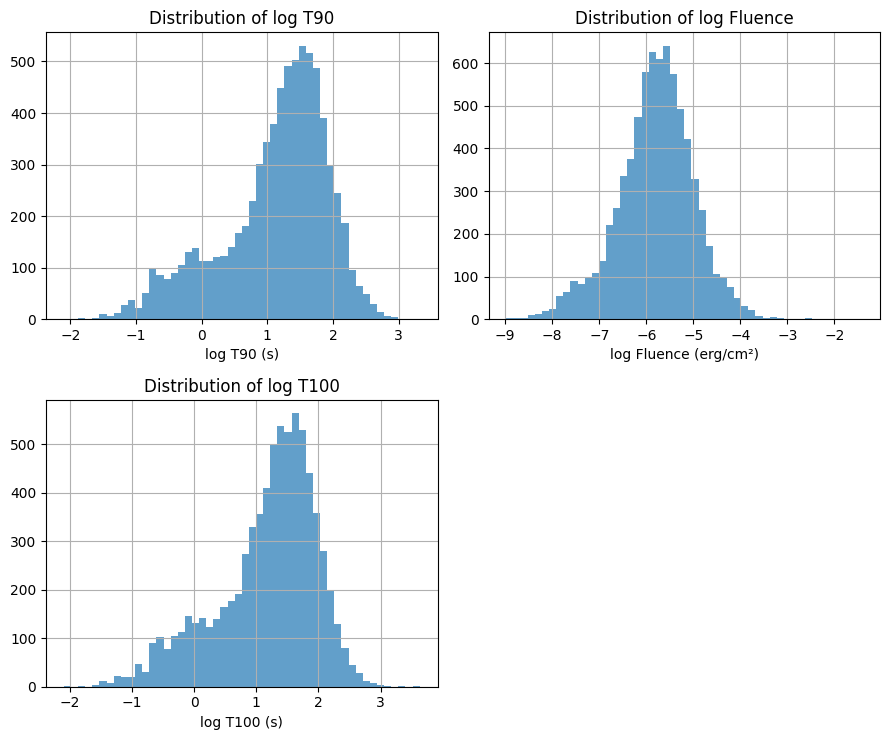

In [125]:
# 2. Plot marginal distributions
plt.figure(figsize=(9, 7.5))
plt.subplot(2,2,1)
plt.hist(log_t90, bins=50, alpha=0.7)
plt.xlabel('log T90 (s)')
plt.title('Distribution of log T90')
plt.grid(True)

plt.subplot(2,2,2)
plt.hist(log_fluence, bins=50, alpha=0.7)
plt.xlabel('log Fluence (erg/cm²)')
plt.title('Distribution of log Fluence')
plt.grid(True)


plt.subplot(2,2,3)
plt.hist(log_t100, bins=50, alpha=0.7)
plt.xlabel('log T100 (s)')
plt.title('Distribution of log T100')
plt.grid(True)



plt.tight_layout()
plt.show()

DBSCAN detected 69 outliers


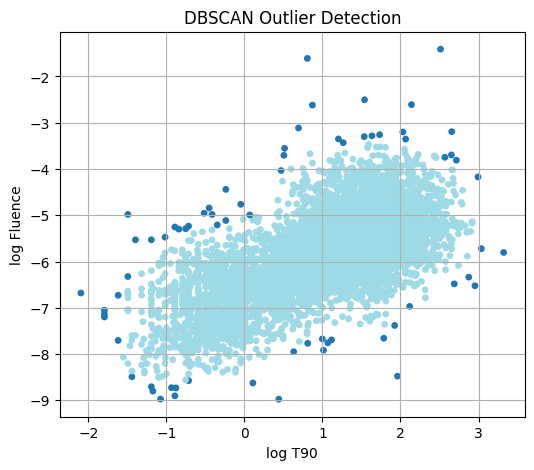

Keeping outliers


In [126]:
# Outliers via DBSCAN
db = DBSCAN(eps=0.3, min_samples=15).fit(Dati)
core, labels = db.core_sample_indices_, db.labels_
n_out = np.sum(labels == -1)
print(f"DBSCAN detected {n_out} outliers")

plt.figure(figsize=(6,5))
plt.scatter(Dati[:,0], Dati[:,1], c=labels, cmap='tab20', s=15)
plt.xlabel('log T90'); plt.ylabel('log Fluence')
plt.title('DBSCAN Outlier Detection')
plt.grid(True)
plt.show()

remove_outliers = False
if remove_outliers:
    X = Dati[labels != -1]
    print("Removing outliers")
else:
    X = Dati
    print("Keeping outliers")
    

Best k for KMeans (Silhouette): 2


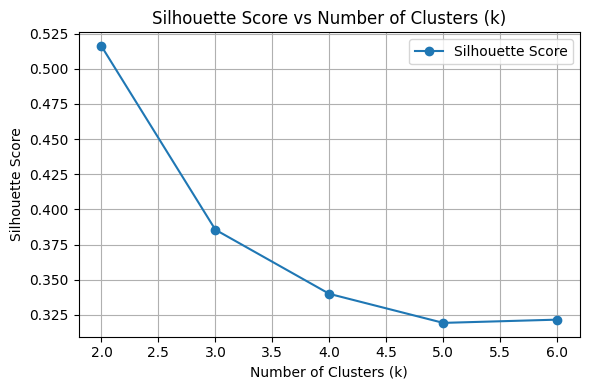

Best k for GMM (AIC): 3


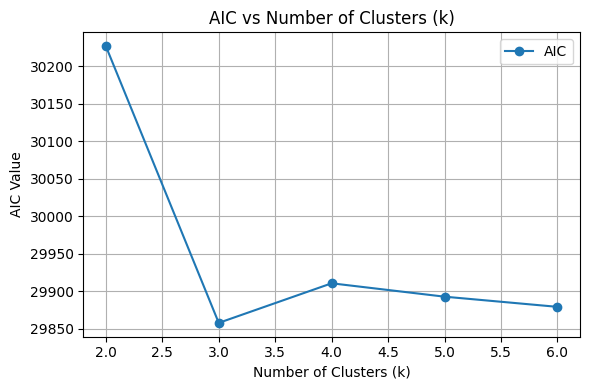

Estimated bandwidth: 0.7399
MeanShift found 3 clusters


In [127]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Find best k for KMeans via Silhouette score
sil_scores = {}
ks = range(2, 7)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels)
best_k_kmeans = max(sil_scores, key=sil_scores.get)
print(f"Best k for KMeans (Silhouette): {best_k_kmeans}")

# Plot AIC values as a function of k
plt.figure(figsize=(6, 4))
plt.plot(ks, list(sil_scores.values()), marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find best k for GMM via AIC
aic_scores = {}
for k in ks:
    gm = GaussianMixture(n_components=k, random_state=0)
    gm.fit(X)
    aic_scores[k] = gm.aic(X)
best_k_gmm = min(aic_scores, key=aic_scores.get)
print(f"Best k for GMM (AIC): {best_k_gmm}")

# Plot AIC values as a function of k
plt.figure(figsize=(6, 4))
plt.plot(ks, aic_scores.values(), marker='o', label='AIC')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('AIC Value')
plt.title('AIC vs Number of Clusters (k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# X è il tuo array di dati di forma (n_samples, n_features)
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)  # puoi regolare quantile
print(f"Estimated bandwidth: {bandwidth:.4f}")

ms = MeanShift(bandwidth=bandwidth)
# MeanShift clustering
ms = MeanShift()
ms_labels = ms.fit_predict(X)
n_ms = len(np.unique(ms_labels))
print(f"MeanShift found {n_ms} clusters")


# 4. Fit final models
km_final = KMeans(n_clusters=best_k_kmeans, random_state=0).fit(X)
labels_km = km_final.labels_

gm_final = GaussianMixture(n_components=best_k_gmm, random_state=0).fit(X)
labels_gm = gm_final.predict(X)



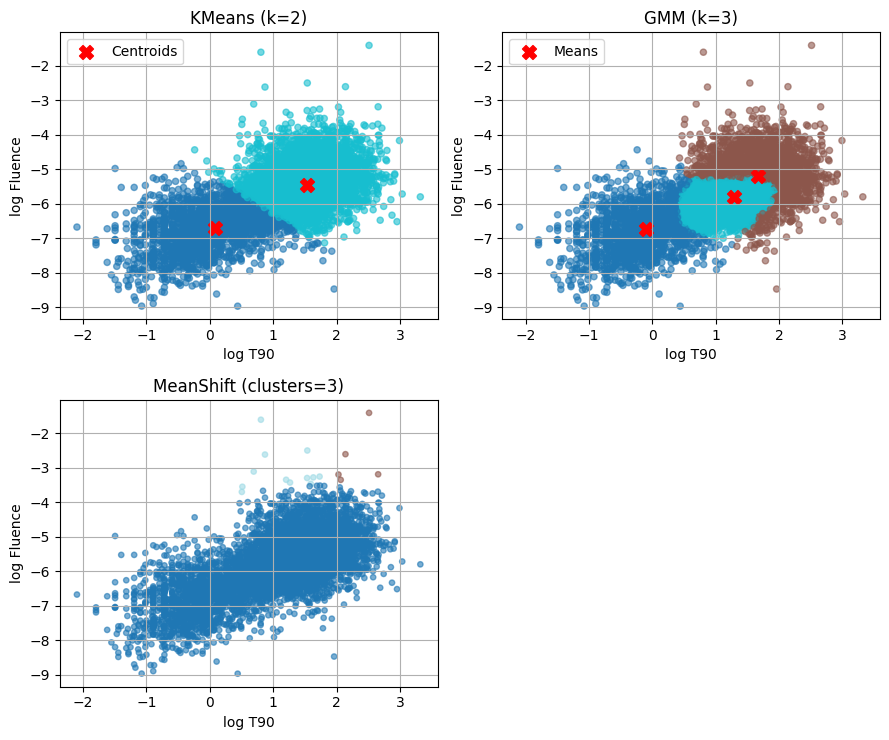

In [128]:
plt.figure(figsize=(9, 7.5))

plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_km, cmap='tab10', s=20, alpha=0.6)
# plot centroids
centers = km_final.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title(f'KMeans (k={best_k_kmeans})')
plt.xlabel('log T90')
plt.ylabel('log Fluence')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_gm, cmap='tab10', s=20, alpha=0.6)
# plot GMM means
means = gm_final.means_
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100, label='Means')
plt.title(f'GMM (k={best_k_gmm})')
plt.xlabel('log T90')
plt.ylabel('log Fluence')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.scatter(X[:, 0], X[:, 1], c=ms_labels, cmap='tab20', s=15, alpha=0.6)
plt.title(f"MeanShift (clusters={n_ms})")
plt.xlabel('log T90')
plt.ylabel('log Fluence')
plt.grid(True)

plt.tight_layout()
plt.show()

In [66]:
# 6. Compute threshold between classes for KMeans on log T90
centroids = km_final.cluster_centers_
# centroids[:,0] are log T90 coords of each cluster center
t90_centroids = centroids[:, 0]
sorted_centroids = np.sort(t90_centroids)
if len(sorted_centroids) >= 2:
    thr_log_t90 = np.mean(sorted_centroids[:2])
    thr_t90 = 10**thr_log_t90
    print(f"Threshold in log T90 between first two clusters: {thr_log_t90:.2f}")
    print(f"Threshold in T90 (seconds): {thr_t90:.2f} s")
else:
    thr_log_t90 = None

Threshold in log T90 between first two clusters: 0.75
Threshold in T90 (seconds): 5.64 s


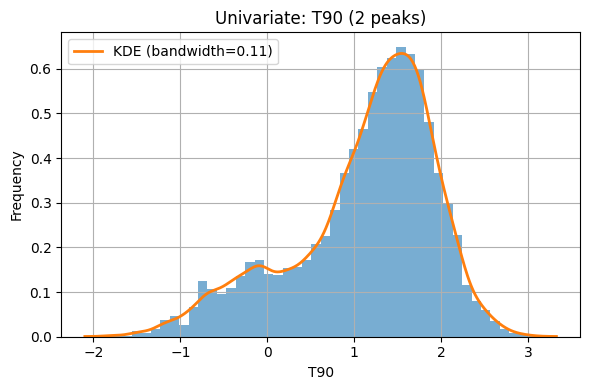

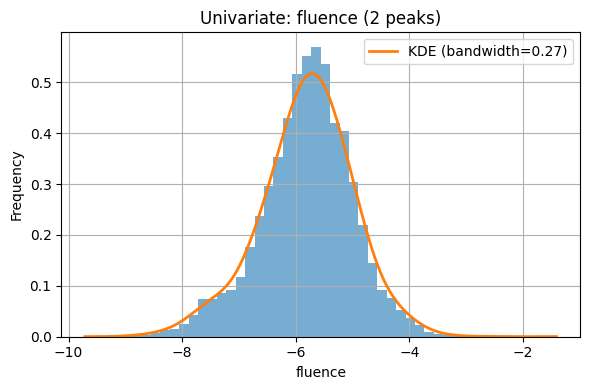

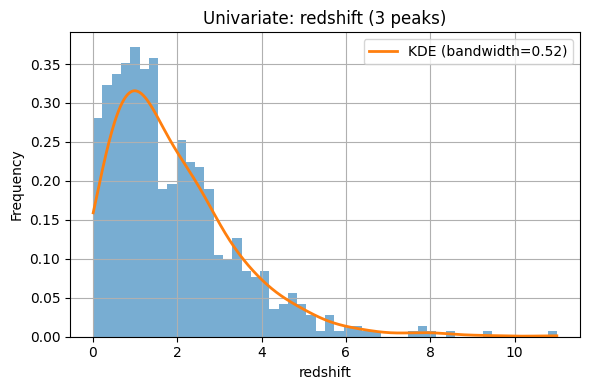

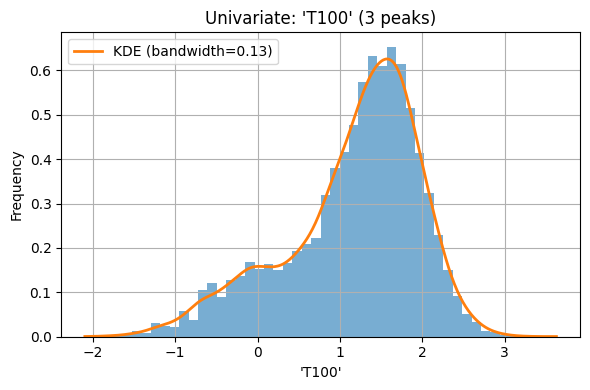

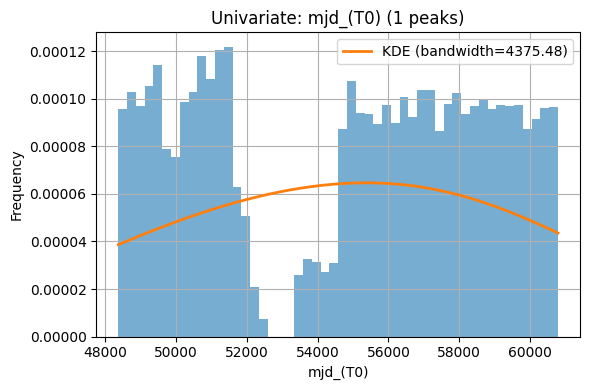

In [102]:
from sklearn.model_selection import GridSearchCV

# Build DataFrame of numeric data (non-numeric → NaN)
data = {}
for i, col in enumerate(names):
    data[col] = formatted[:, i]


# Replace -999 with NaN in the data
for key in data:
    data[key] = np.where(data[key] == -999, np.nan, data[key])
    


df = pd.DataFrame(data)



# 2. Univariate Exploration
# 2.1 Histograms + Optimized KDE for each numeric variable
for col in df.columns:
    
    x = df[col].values
    x = x[~np.isnan(x)]  # Remove NaN values
    
    
    if col == 'T90' or col == 'fluence' or col == "'T100'":
        x = x[x > 0]  # Remove negative or zero values
        x = np.log10(x)
        
    if col == 'ra' or col == 'decl':
        continue


    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=50, alpha=0.6, density=True)

    # Grid search for optimal bandwidth using cross-validation
    magnitude = int(np.floor(np.log10(np.abs(x).max())))
    bwrange = np.logspace(magnitude - 2, magnitude + 2, 40)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bwrange}, cv=5)
    grid.fit(x[:, None])
    h_opt = grid.best_params_['bandwidth']

    # Fit KDE with optimal bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(x[:, None])
    x_grid = np.linspace(x.min(), x.max(), 500)[:, None]
    dens = np.exp(kde.score_samples(x_grid))

    # Find peaks
    peaks, _ = find_peaks(dens)

    # Plot the best KDE
    plt.plot(x_grid.ravel(), dens, lw=2, label=f'KDE (bandwidth={h_opt:.2f})')
    plt.title(f"Univariate: {col} ({len(peaks)} peaks)")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



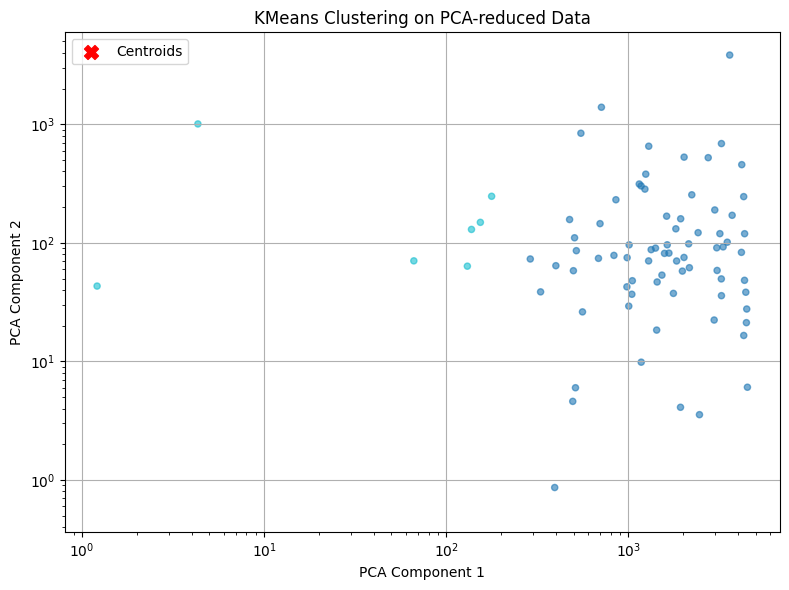

Best k for GMM (AIC): 11


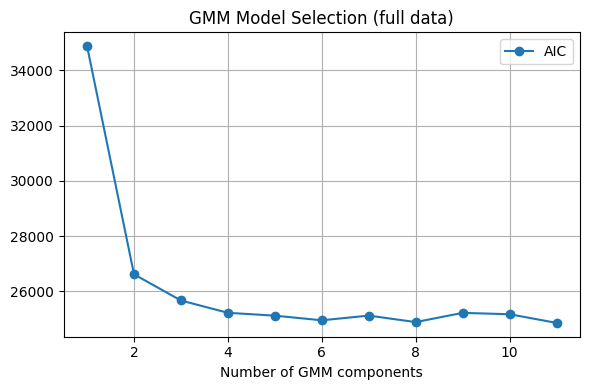

In [104]:
# 4. Dimensionality reduction + 2D clustering visualization
df_all = df.dropna()

# 4.1 PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_all)
# Perform clustering with KMeans
kmeans_vis = KMeans(n_clusters=2, random_state=42).fit(X_pca)
labels_vis = kmeans_vis.labels_

# Plot the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_vis, cmap='tab10', s=20, alpha=0.6)
# Plot centroids
centroids_vis = kmeans_vis.cluster_centers_
plt.scatter(centroids_vis[:, 0], centroids_vis[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('KMeans Clustering on PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. GMM in full 15D: AIC/BIC profiling for k=1..6
aic_vals = []
ks = range(1,12)
for k in ks:
    gm = GaussianMixture(n_components=k, random_state=0)
    gm.fit(df_all)
    aic_vals.append(gm.aic(df_all))

print(f"Best k for GMM (AIC): {ks[np.argmin(aic_vals)]}")
plt.figure(figsize=(6,4))
plt.plot(ks, aic_vals, marker='o', label='AIC')
plt.xlabel('Number of GMM components')

plt.title('GMM Model Selection (full data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
